In [39]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [3]:
df = pd.read_csv("resources/train.csv")
df

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0000,65.0000,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0000,65.0000,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0000,65.0000,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0000,65.0000,2020-01-26,0.0,0.0
...,...,...,...,...,...,...,...,...
16751,26374,NaN,Zambia,-15.4167,28.2833,2020-03-16,0.0,0.0
16752,26375,NaN,Zambia,-15.4167,28.2833,2020-03-17,0.0,0.0
16753,26376,NaN,Zambia,-15.4167,28.2833,2020-03-18,2.0,0.0
16754,26377,NaN,Zambia,-15.4167,28.2833,2020-03-19,2.0,0.0


In [4]:
df.describe()

,Id,Lat,Long,ConfirmedCases,Fatalities
count,16756.000000,16697.000000,16697.000000,16756.000000,16756.000000
mean,13189.500000,26.337324,5.039603,271.750119,9.221533
std,7624.686932,22.963063,79.935267,3261.152305,141.524582
min,1.000000,-41.454500,-157.498300,0.000000,0.000000
25%,6595.250000,13.193900,-71.530100,0.000000,0.000000
50%,13189.500000,33.000000,10.000000,0.000000,0.000000
75%,19783.750000,42.506300,65.000000,7.000000,0.000000
max,26378.000000,72.000000,174.886000,67800.000000,4032.000000


In [5]:
df["Country/Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cruise Ship', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Finland', 'France', 'French Guiana', 'Gabon', 'Gambia, The',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guadeloupe',
       'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guyana', 'Holy See',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia

In [35]:
data = df[df["Country/Region"].isin(["China", "US", "Italy", "Spain"])]
data

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
2773,4372,Anhui,China,31.8257,117.2264,2020-01-22,1.0,0.0
2774,4373,Anhui,China,31.8257,117.2264,2020-01-23,9.0,0.0
2775,4374,Anhui,China,31.8257,117.2264,2020-01-24,15.0,0.0
2776,4375,Anhui,China,31.8257,117.2264,2020-01-25,39.0,0.0
2777,4376,Anhui,China,31.8257,117.2264,2020-01-26,60.0,0.0
...,...,...,...,...,...,...,...,...
16043,25258,Wyoming,US,42.7560,-107.3025,2020-03-16,3.0,0.0
16044,25259,Wyoming,US,42.7560,-107.3025,2020-03-17,11.0,0.0
16045,25260,Wyoming,US,42.7560,-107.3025,2020-03-18,15.0,0.0
16046,25261,Wyoming,US,42.7560,-107.3025,2020-03-19,18.0,0.0


In [74]:
data = data.groupby(["Date", 'Country/Region']).sum().reset_index()
data["Date"] = pd.to_datetime(data["Date"])


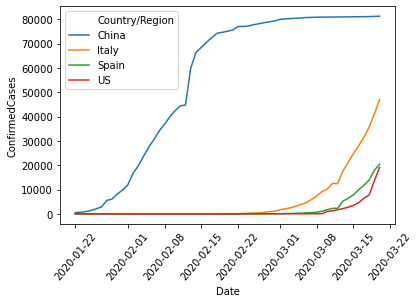

In [75]:
c = sns.lineplot(x='Date', y='ConfirmedCases', hue="Country/Region", data=data)
#c.format_xdata = mdates.DateFormatter('%Y-%m-%d')

c.xaxis.set_tick_params(rotation=50)

In [112]:
def ds_dt (beta, S, I, N):
    ds_dt = -1.0* beta * I/N * S
    return ds_dt

def di_dt (beta, gamma, S, I, N):
    di_dt = beta * I/N * S - gamma * I
    return di_dt

def dr_dt (gamma, I, N):
    dr_dt = gamma * I
    return dr_dt

In [159]:
n = 7.9*(10**6)
s = n-100
i = 100
r = 0
beta0 = 0.3
gamma0 = 0.2

sus, inf, rec= [],[],[]
    
days = range(1000)

for d in days:
    delta_s = ds_dt(beta0, s, i, n)
    delta_i = di_dt(beta0, gamma0, s, i, n)
    delta_r = dr_dt(gamma0, i, n)
    s += delta_s
    i += delta_i
    r += delta_r
    sus.append(s/n)
    inf.append(i/n)
    rec.append(r/n)
    
    

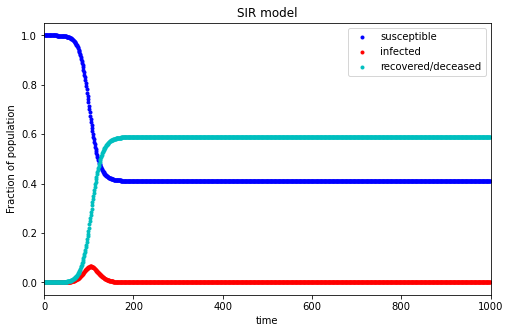

In [160]:
f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,len(days))
plt.savefig('SIR_example.png')
plt.show()